In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os 

PATH = Path('/home/fergus/data/icloud_data/raw_icloud/')

def load_photo(fn):
    img = io.imread(fn)[...,:3]
    return img 

fn = [x for x in PATH.iterdir()][0]
print(fn)


/home/fergus/data/icloud_data/raw_icloud/IMG_4275.jpg


In [3]:
import tensorflow as tf

2023-08-02 20:13:04.393408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 20:13:04.988612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
%%bash
nvidia-smi

Wed Aug  2 20:13:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  Off |
|  0%   34C    P8    31W / 450W |     19MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from tensorflow.keras.applications.convnext import ConvNeXtTiny

In [6]:
model = tf.keras.applications.ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

2023-08-02 20:13:05.845186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-02 20:13:05.919404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-02 20:13:05.919615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
model.outputs

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'layer_normalization')>]

# Finetuning on my dataset 

In [8]:
import fiftyone as fo


dataset = fo.load_dataset("icloud")

In [10]:
# Create a view containing only labeled samples
labeled_view = dataset.match({"('new_field',)": {"$exists": True}})
labeled_view

Dataset:     icloud
Media type:  image
Num samples: 298
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    tfrecord:       fiftyone.core.fields.BooleanField
    ('new_field',): fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
View stages:
    1. Match(filter={"('new_field',)": {'$exists': True}})

In [12]:
import matplotlib.pyplot as plt 

images, labels = [], []
for img in labeled_view:
    #print(img)
    filepath: str = img.filepath
    a_labels = []
    for classification in img["('new_field',)"].classifications:
        a_labels.append(classification.label)
    image = tf.io.decode_jpeg(tf.io.read_file(filepath))
    images.append(image)
    labels.append(a_labels)
print(len(images)),  print(len(labels))                            


298
298


(None, None)

In [13]:
# resizing 
images = [tf.image.resize(image, [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) for image in images]

In [14]:
images_dataset = tf.data.Dataset.from_tensor_slices(images)

In [15]:
fergus_labels = [1 if 'fergus' in label else 0 for label in labels]
labels_dataset = tf.data.Dataset.from_tensor_slices(fergus_labels)

In [16]:
dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((images, fergus_labels))

# Preparing new model

In [38]:

def get_model():
    inputs = model.inputs
    x = model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation=tf.nn.softmax)(x)
    outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(x)
    finetune_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    for layer in finetune_model.get_layer(name='convnext_tiny').layers:
        layer.trainable = False
    return finetune_model
finetune_model = get_model()
finetune_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 convnext_tiny (Functional)  (None, None, None, 768)   27820128  
                                                                 
 global_average_pooling2d_15  (None, 768)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_30 (Dense)            (None, 256)               196864    
                                                                 
 dense_31 (Dense)            (None, 2)                 514       
                                                                 
Total params: 28,017,506
Trainable params: 197,378
Non-trainable params: 27,820,128
________________________________________

In [39]:
from sklearn.metrics import accuracy_score 
import numpy as np

def model_eval():
    preds = []
    for img, label in dataset:
        pred = finetune_model(img)
        preds.append(np.argmax(pred.numpy()))
    return preds

preds = model_eval()

In [40]:
accuracy_score(fergus_labels, preds)

0.3624161073825503

nice random prediction head = random guessing

# Training

In [41]:
finetune_model = get_model()
opt = tf.keras.optimizers.AdamW(learning_rate=0.1)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
finetune_model.compile(optimizer=opt, loss=bce)
history = finetune_model.fit(dataset.batch(16), epochs=10)

Epoch 1/10


2023-08-02 20:24:26.468272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [298]
	 [[{{node Placeholder/_1}}]]


19/19 [==============================] - 5s 34ms/step - loss: 0.6968
Epoch 2/10
19/19 [==============================] - 1s 30ms/step - loss: 0.6935
Epoch 3/10
19/19 [==============================] - 1s 29ms/step - loss: 0.6932
Epoch 4/10
19/19 [==============================] - 1s 29ms/step - loss: 0.6932
Epoch 5/10
19/19 [==============================] - 1s 30ms/step - loss: 0.6931
Epoch 6/10
19/19 [==============================] - 1s 29ms/step - loss: 0.6931
Epoch 7/10
19/19 [==============================] - 1s 30ms/step - loss: 0.6931
Epoch 8/10
19/19 [==============================] - 1s 30ms/step - loss: 0.6931
Epoch 9/10
19/19 [==============================] - 1s 29ms/step - loss: 0.6931
Epoch 10/10
19/19 [==============================] - 1s 29ms/step - loss: 0.6931


In [42]:
history.history

{'loss': [0.6968469023704529,
  0.6934947371482849,
  0.6931931376457214,
  0.6931541562080383,
  0.6931479573249817,
  0.6931470036506653,
  0.6931469440460205,
  0.693146824836731,
  0.693146824836731,
  0.6931468844413757]}

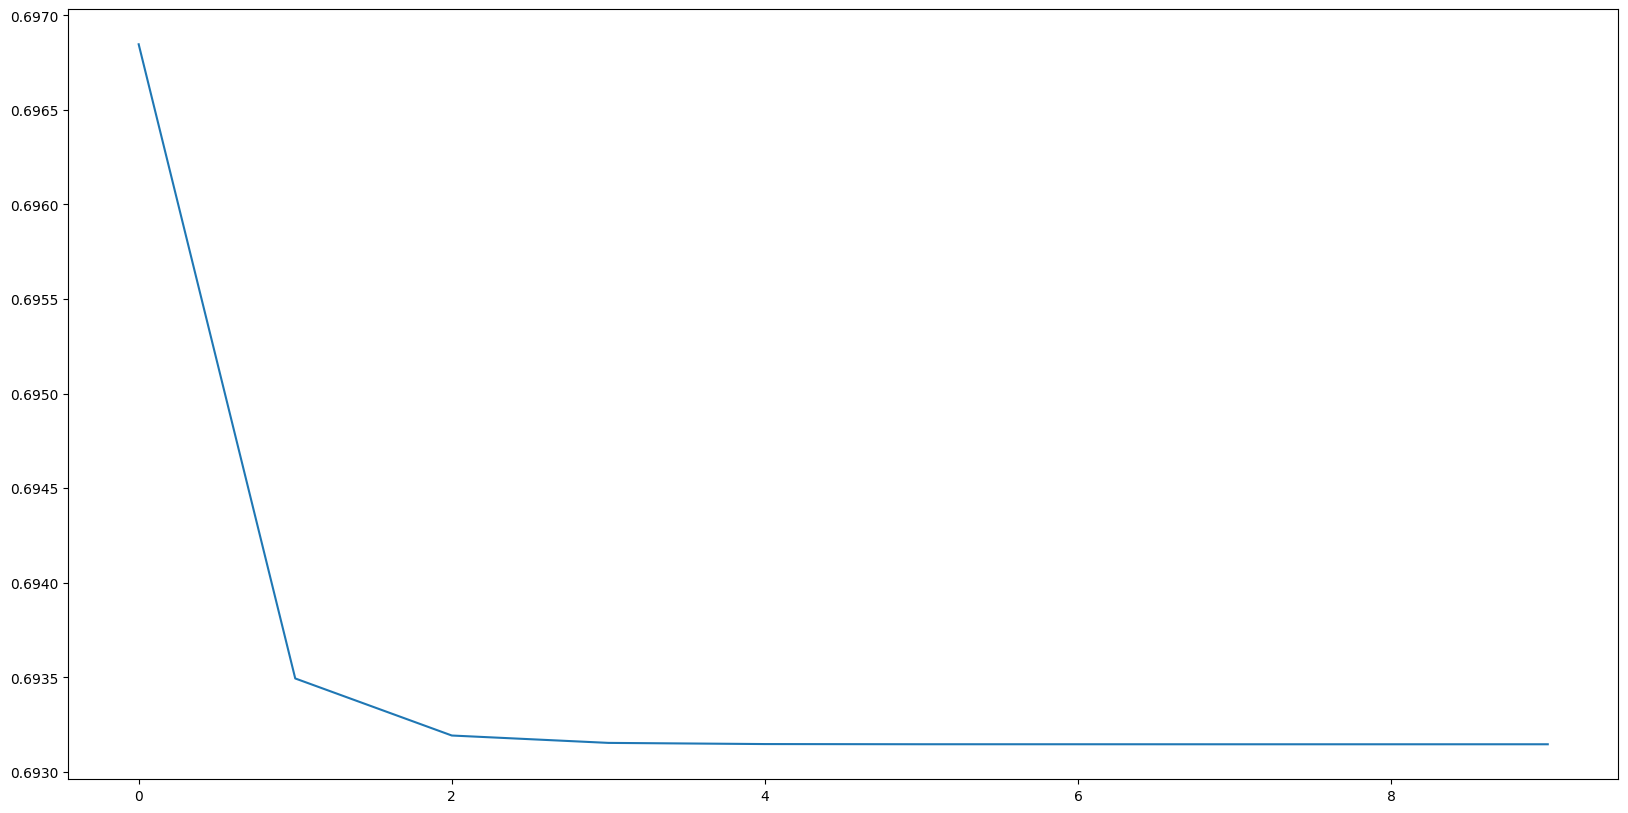

In [43]:
fig, axs = plt.subplots(1,1,figsize=(20,10))
axs.plot(np.arange(10), history.history['loss'])

loss doesn't change, but have no data. 